# Comparison of Dina startup to TokaMaker (recreate EQ only w/ eddy currents)

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

In [3]:
def read_coil_currs(filename):
    with open(filename,'r') as fid:
        fid.readline()
        fid.readline()
        fid.readline()
        vals = np.array([float(val) for val in fid.readline().split()])
    return vals
def read_vv_currs(filename):
    vals = []
    with open(filename,'r') as fid:
        fid.readline()
        fid.readline()
        fid.readline()
        vals += [float(val) for val in fid.readline().split()]
        vals += [float(val) for val in fid.readline().split()]
        vals += [float(val) for val in fid.readline().split()]
    return np.array(vals)

# Inputs

In [4]:
time_pt = 50
eqdsk = read_eqdsk('1MA_eqdsk_currs/{0:d}msec/nsf_ntt.{0:06d}'.format(time_pt))
coil_currs = read_coil_currs('1MA_eqdsk_currs/{0:d}msec/fc.txt'.format(time_pt))
vv_currs = read_vv_currs('1MA_eqdsk_currs/{0:d}msec/tcam.txt'.format(time_pt))

In [5]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('nextstep_mesh-dina.h5')

In [6]:
myOFT = OFT_env()
mygs = TokaMaker(myOFT)
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2, F0=eqdsk['rcentr']*eqdsk['bcentr']) ## F0 = B0 * R0

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   string_len_def
Revision id:          7014d26
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                                                                                                                                                 
XML input file        = none                                                                                                                                                                                                    
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.914E+00
    # of points  =  

In [7]:
coil_regmat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E4*np.ones((mygs.ncoils+1,), dtype=np.float64)
coil_reg_targets = np.zeros((mygs.ncoils+1,), dtype=np.float64)

for i in range(vv_currs.shape[0]):
    coil_reg_targets[mygs.coil_sets['VV_{0}'.format(i+1)]['id']] = vv_currs[i]*1000.0
    coil_reg_weights[mygs.coil_sets['VV_{0}'.format(i+1)]['id']] = 1.E4

imap = [0,1,2,3,10,4,9,5,8,6,7,-1,-1,12,11]
for key, coil_set in mygs.coil_sets.items():
    i = coil_set['id']
    if i >= len(imap):
        break
    if imap[i] < 0:
        continue
    coil_reg_targets[i] = coil_currs[imap[i]]*1000.0
    coil_reg_weights[i] = 1.E-1

# Terms for virtual VSC coil (unused)
coil_reg_weights[-1] = 1.E4

mygs.set_coil_reg(coil_regmat,reg_weights=coil_reg_weights,reg_targets=coil_reg_targets)

In [8]:
ffprim = eqdsk['ffprim']
pprime = eqdsk['pprime']


psi_eqdsk = np.linspace(0.0,1.0,np.size(ffprim))
psi_sample = np.linspace(0.0,1.0,np.size(ffprim))

psi_prof = np.copy(psi_sample)
ffp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,ffprim)))).copy()
pp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,pprime)))).copy()

mygs.set_profiles(ffp_prof={'type': 'linterp', 'y': ffp_prof[:,1], 'x': psi_sample},pp_prof={'type': 'linterp', 'y': pp_prof[:,1], 'x': psi_sample})

In [9]:
mygs.set_targets(Ip = eqdsk['ip'], pax=eqdsk['pres'][0])

In [10]:
isoflux_pts = eqdsk['rzout'].copy()
mygs.set_isoflux(isoflux_pts)

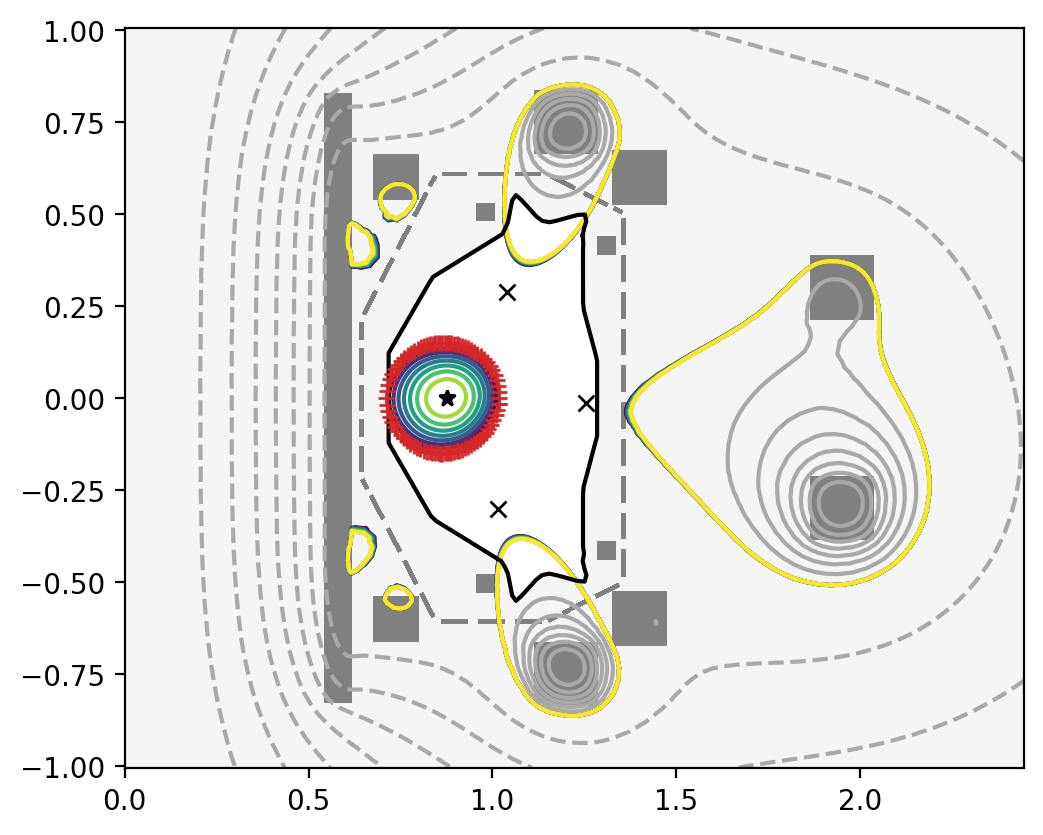

In [11]:
mygs.init_psi(1,0,0.25, 1.7,-0.5)
fig, ax = plt.subplots()
mygs.plot_psi(fig,ax)
mygs.plot_machine(fig,ax)
mygs.plot_constraints(fig,ax)

In [12]:
mygs.solve()
mygs.print_info()

Starting non-linear GS solver
     1  1.2408E+00  1.3598E-05  3.4757E-04  8.7301E-01  1.7364E-04 -0.0000E+00
     2  2.0305E+00  1.8770E-06  1.2543E-04  8.7106E-01  1.2550E-04 -0.0000E+00
     3  2.1471E+00  1.3885E-06  4.1265E-05  8.7050E-01 -1.1815E-04 -0.0000E+00
     4  2.1754E+00  1.2975E-06  1.4933E-05  8.7003E-01 -1.3846E-04 -0.0000E+00
     5  2.1820E+00  1.2761E-06  6.1227E-06  8.6978E-01 -1.4944E-04 -0.0000E+00
     6  2.1829E+00  1.2711E-06  2.7433E-06  8.6965E-01 -1.5536E-04 -0.0000E+00
     7  2.1826E+00  1.2700E-06  1.2901E-06  8.6959E-01 -1.5855E-04 -0.0000E+00
     8  2.1823E+00  1.2699E-06  6.2053E-07  8.6956E-01 -1.6025E-04 -0.0000E+00
 Timing:  0.44860199999948236     
   Source:    0.17290899999989051     
   Solve:      1.9784000000072410E-002
   Boundary:   8.5079999989829957E-003
   Other:     0.24740100000053644     
Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    2.2867E+04
  Current Centroid [m]    =    0.863 -0.000

In [13]:
mygs.save_eqdsk('Comparisons/NSFSim_TokaMaker-EQ_{0}.eqdsk'.format(time_pt))

Saving EQDSK file: Comparisons/NSFSim_TokaMaker-EQ_50.eqdsk


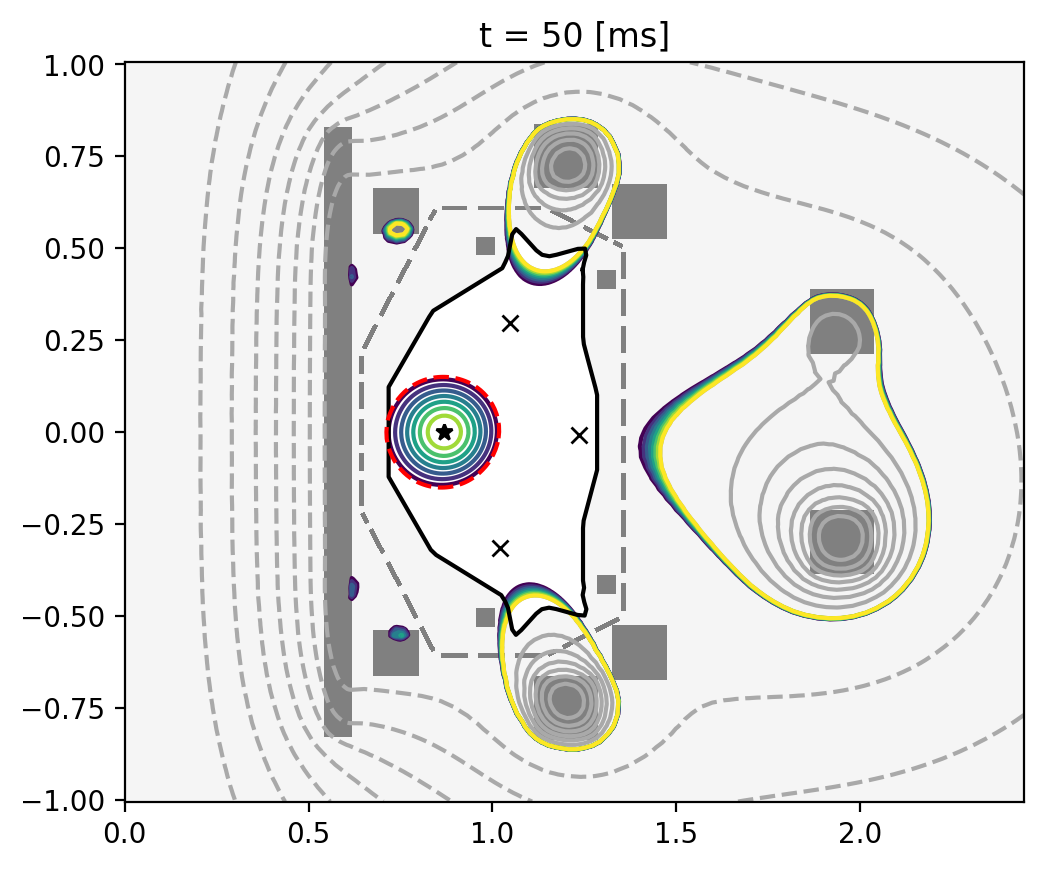

In [14]:
fig, ax = plt.subplots()
mygs.plot_psi(fig,ax)
mygs.plot_machine(fig,ax)
# mygs.plot_constraints(fig,ax)
ax.plot(eqdsk['rzout'][:,0],eqdsk['rzout'][:,1],'r--')
ax.set_title('t = {0} [ms]'.format(time_pt))
fig.savefig('Comparisons/NSFSim_TokaMaker-EQ_{0}.png'.format(time_pt),dpi=200)

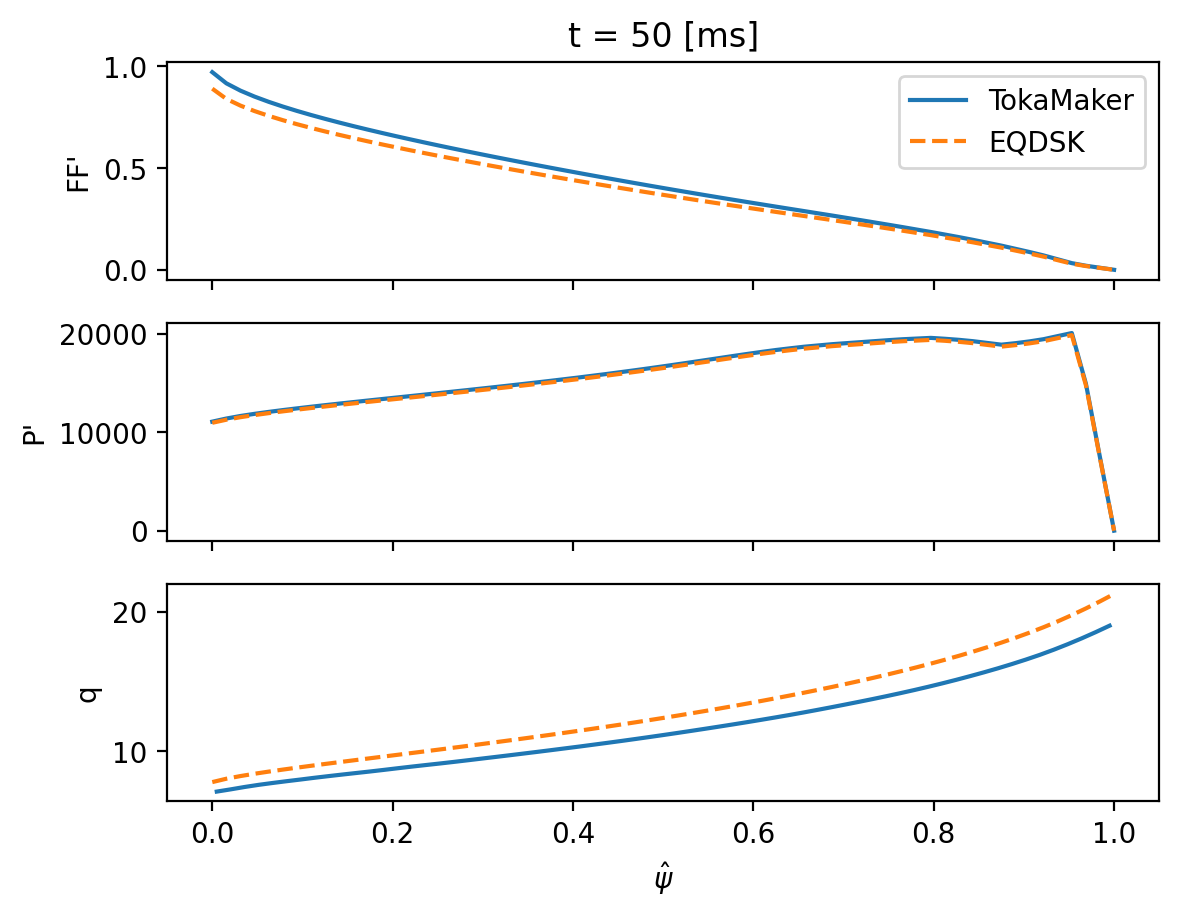

In [15]:
psi,f,fp,p,pp = mygs.get_profiles(npsi=np.size(ffprim))
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi_pad=0.005,npsi=np.size(ffprim))
fig, ax = plt.subplots(3,1,sharex=True)
psi_eqdsk = np.linspace(0.0,1.0,eqdsk['nr'])
psi_sample = np.linspace(0.025,1.0,10)
# Plot F*F'
ax[0].plot(psi,f*fp,label='TokaMaker')
ax[0].plot(psi_eqdsk,eqdsk['ffprim'],'--',label='EQDSK')
ax[0].set_ylabel("FF'")
ax[0].legend()
ax[0].set_title('t = {0} [ms]'.format(time_pt))
# Plot P'
ax[1].plot(psi,pp)
ax[1].plot(psi_eqdsk,eqdsk['pprime'],'--')
ax[1].set_ylabel("P'")
# Plot q
ax[2].plot(psi_q,qvals)
ax[2].plot(psi_eqdsk,eqdsk['qpsi'],'--')
ax[2].set_ylabel("q")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")
fig.savefig('Comparisons/NSFSim_TokaMaker-profiles_{0}.png'.format(time_pt),dpi=200)

In [16]:
tMaker_currs, _ = mygs.get_coil_currents()
# imap = [0,1,2,3,10,4,9,5,8,6,7,11,12]
with open('Comparisons/NSFSim_TokaMaker-coils_{0}.dat'.format(time_pt), 'w+') as fid:
    fid.write('# Coil, TokaMaker, NSFSim\n')
    for key, coil_set in mygs.coil_sets.items():
        if key.startswith('VV'):
            break
        i = coil_set['id']
        if i < len(imap) and imap[i] >= 0:
            print('{2} {0:.3E} {1:.3E}'.format(tMaker_currs[i],coil_currs[imap[i]]*1000.0,key))
            fid.write('{2}, {0:E}, {1:E}\n'.format(tMaker_currs[i],coil_currs[imap[i]]*1000.0,key))
        else:
            print('{1} {0:.3E}'.format(tMaker_currs[i],key))
            fid.write('{1}, {0:E}, NaN\n'.format(tMaker_currs[i],key))

CS_1 2.993E+06 2.993E+06
CS_2 4.832E+06 4.832E+06
CS_3 3.004E+06 3.004E+06
PF_1U 3.787E+05 3.783E+05
PF_1L 3.507E+05 3.503E+05
PF_2U 9.429E+05 9.426E+05
PF_2L 1.062E+06 1.062E+06
PF_3U -1.629E+05 -1.630E+05
PF_3L -3.315E+05 -3.311E+05
PF_4U 1.766E+05 1.770E+05
PF_4L 4.398E+05 4.403E+05
DIV_1U 8.399E-08
DIV_1L 2.652E-08
DIV_2U 1.773E+03 1.658E+03
DIV_2L -7.198E+02 1.630E+01
